# Edmonton Property Price Prediction Using FastAI
The machine learning workflow in this notebook is mostly pulled from the FastAI tabular models lesson.

### Goal:
Build a housing model that predicts assessed value.

### Importing and Loading Dataset

In [1]:
from fastai import *
from fastai.tabular import *

In [2]:
path = 'datasets/edmonton-property.csv'
df = pd.read_csv(path)

Need to specify processing, categorical names, continuous names, and the dependent variable.

In [3]:
df.head()

,Account Number,Suite,House Number,Street Name,Assessed Value,Assessment Class,Neighbourhood ID,Neighbourhood,Ward,Garage,Latitude,Longitude
0,8392904,NaN,9035.0,90 STREET NW,352500,Residential,6040.0,BONNIE DOON,Ward 8,Y,53.526362,-113.464935
1,10063906,NaN,1535.0,37B AVENUE NW,382500,Residential,6443.0,TAMARACK,Ward 11,Y,53.473516,-113.366455
2,4252557,NaN,8409.0,156 AVENUE NW,348000,Residential,2050.0,BELLE RIVE,Ward 3,Y,53.616207,-113.472303
3,10512253,NaN,7046.0,NEWSON ROAD NW,168000,Residential,3111.0,GRIESBACH,Ward 2,N,53.608989,-113.513399
4,8855603,NaN,7112.0,82 STREET NW,370500,Residential,6020.0,AVONMORE,Ward 11,Y,53.507129,-113.453902


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405973 entries, 0 to 405972
Data columns (total 12 columns):
Account Number      405973 non-null int64
Suite               80070 non-null object
House Number        362201 non-null float64
Street Name         362201 non-null object
Assessed Value      405973 non-null int64
Assessment Class    405973 non-null object
Neighbourhood ID    405972 non-null float64
Neighbourhood       405972 non-null object
Ward                405972 non-null object
Garage              405973 non-null object
Latitude            405973 non-null float64
Longitude           405973 non-null float64
dtypes: float64(4), int64(2), object(6)
memory usage: 37.2+ MB


## Process and Visualize Data
Basic Histogram getting used, can only be used on columns with only numbers.

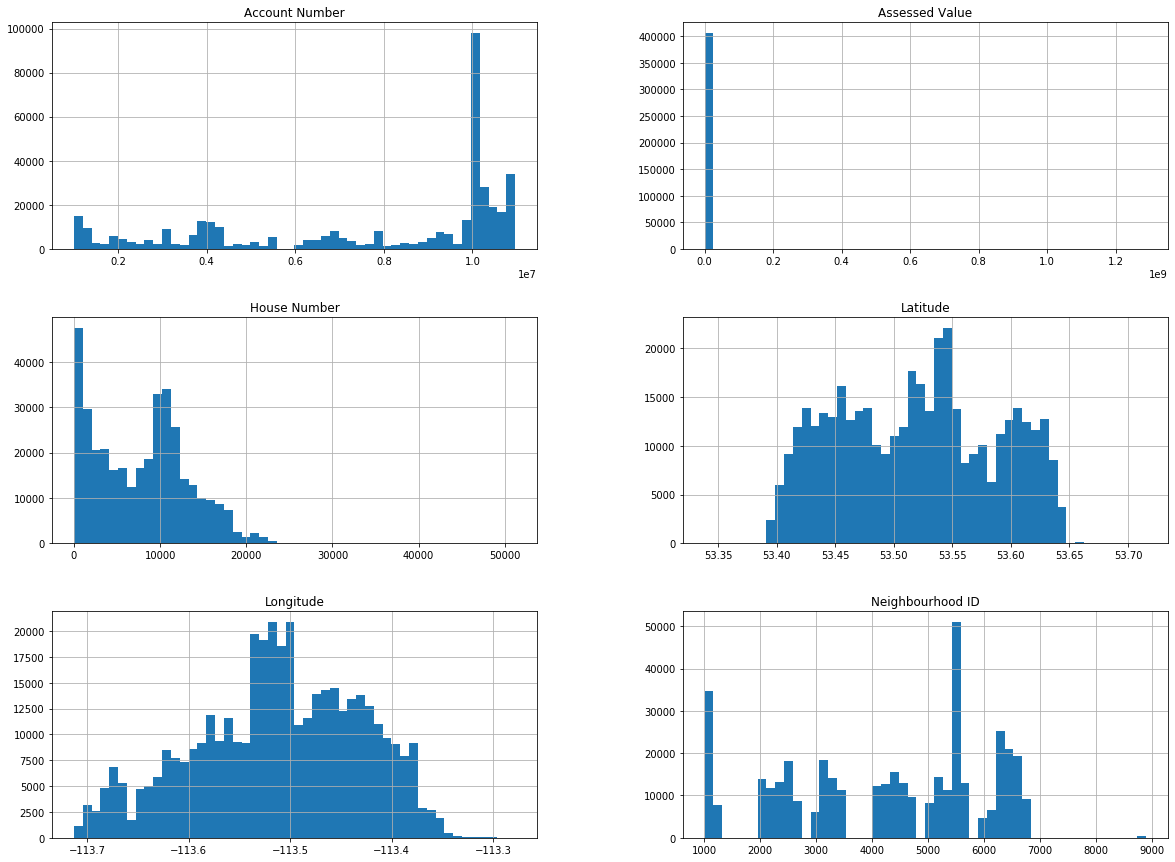

In [5]:
%matplotlib inline
df.hist(bins=50, figsize=(20, 15))
plt.show()

### Evaluating Each Column

In [6]:
for col in df.columns:
    print(col, df[col].nunique())

Account Number 405973
Suite 1892
House Number 18570
Street Name 2886
Assessed Value 9140
Assessment Class 4
Neighbourhood ID 399
Neighbourhood 399
Ward 12
Garage 2
Latitude 261510
Longitude 261510


### 1. Account Number: Leave Off
Probably not going to be useful. Even if it is, probably not something valid for using in the housing model.

### 2. Suite: Use Later
NOTE: need to clarify way to fill when using with house number.

This could be either categorical, or possibly numeric if higher suite numbers means higher floor? Maybe convert to a new column that just uses floor number?  Will need to do some processing and plotting to decide.

NOTE: Turns out there's a bunch of strings in the suite column.  Will probably need do some regex stuff if i want to use those ones.

NOTE2: Turns out theres the link between suite# and price is a big too sketch to be useful

In [7]:
# want to find most common suite numbers, notice non ints
df.Suite.value_counts().sort_values(ascending=False)

201      1054
202      1016
101       996
203       988
301       969
         ... 
1333        1
D3          1
929         1
4206        1
1-117       1
Name: Suite, Length: 1892, dtype: int64

Definitely should plot the relationship between different suite number derivatives and assessed price.
- First digit vs price
- Full number vs price

In [8]:
full_suite = df[['Suite', 'Assessed Value']]

Need to use Regex to change a bunch of these Suite numbers into integers.  Maybe need to detect the string rows and grab them to look at them.

### Basic Plotting of Suite# vs Assessed Value
First going to make a separate plot of Suite vs Value, after dropping all the rows with string Suites

In [9]:
dropped_suite = full_suite.fillna(1)
dropped_suite.Suite = dropped_suite.Suite.apply(lambda x: pd.to_numeric(x, errors='coerce'))
dropped_suite.Suite = dropped_suite.Suite.dropna()

Apparently tries to convert to numeric, making any fails into NaN, then fills with 1.  In this case i want to drop 

In [10]:
dropped_suite = dropped_suite[dropped_suite.Suite < 1000]
dropped_suite = dropped_suite[dropped_suite["Assessed Value"] < 0.5e9]
x = dropped_suite.Suite
y = dropped_suite["Assessed Value"]

In [11]:
dropped_suite.Suite.sort_values(ascending=False)[10:20]

399742    921.0
296211    918.0
284434    917.0
98145     916.0
169939    915.0
351992    914.0
33521     913.0
68697     913.0
310613    912.0
360297    912.0
Name: Suite, dtype: float64

### Plotting by First Digit

Final: Suite Doesn't really seem useable at the moment. Cleaning the data enough that its plottable seems sketchy.  It's also a question of pipeline for cleaning before it enters the model.

## 3. House Number
Doesn't seem likely, but will do some investigation.

In [12]:
drop_house = df[['House Number', 'Assessed Value']]
drop_house = drop_house.dropna()
drop_house = drop_house[drop_house['House Number'] < 3000]

In [13]:
x = drop_house['House Number']
y = drop_house['Assessed Value']

In [14]:
x.value_counts()

111.0     351
320.0     329
603.0     299
655.0     290
230.0     285
         ... 
2199.0      1
2200.0      1
2894.0      1
2697.0      1
2496.0      1
Name: House Number, Length: 2993, dtype: int64

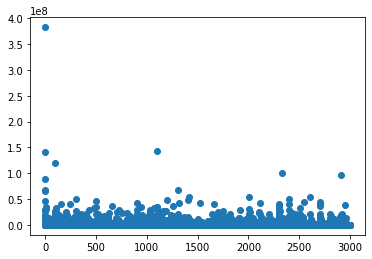

In [15]:
plt.scatter(x, y)

House Number seems kinda random. Not super into it.

## 4. Street Name
This is categorical. Certain streets should definitely have more value.

## 5. Assessed Value
This is the dependent variable to predict.

## 6. Assessment Class
This is categorical. Should def have an impact on prediction.

## 7. Neighbourhood ID
This is a number, but also categorical. Only need either this or Neighbourhood name.

## 8. Neighbourhood
This is just the Neighbourhood. Need either this or NID above.

## 9. Ward
Wards are another category of separation in the city. It could be useful.

## 10. Garage
This is just a categorical saying if the property has a garage or not.  Should be useful

## 11. Latitude
Geographic location x

In [16]:
latx = df.Latitude
y = df['Assessed Value']

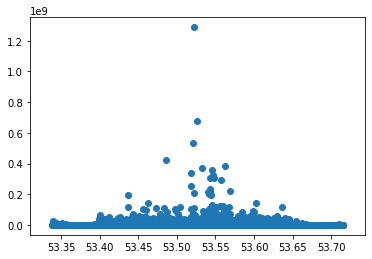

In [17]:
plt.scatter(latx, y)

## 12. Longitude
Same as lat but y

In [18]:
longx = df.Longitude

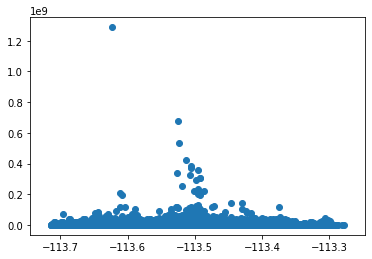

In [19]:
plt.scatter(longx, y)

For latitude and longitude, seems that being in the middle of the city, with a few exceptions, is correlated with property higher value.

In [20]:
df.head(1)

,Account Number,Suite,House Number,Street Name,Assessed Value,Assessment Class,Neighbourhood ID,Neighbourhood,Ward,Garage,Latitude,Longitude
0,8392904,NaN,9035.0,90 STREET NW,352500,Residential,6040.0,BONNIE DOON,Ward 8,Y,53.526362,-113.464935


### Fastai Tabular Data Model

#### Straight From source first, no manual cleaning

In [21]:
df.columns

Index(['Account Number', 'Suite', 'House Number', 'Street Name',
       'Assessed Value', 'Assessment Class', 'Neighbourhood ID',
       'Neighbourhood', 'Ward', 'Garage', 'Latitude', 'Longitude'],
      dtype='object')

In [22]:
dep_var = 'Assessed Value'
cat_names = ['Account Number', 'Suite', 'House Number', 'Street Name', 'Assessment Class', 'Neighbourhood ID', 'Ward', 'Garage']
cont_names = ['Latitude', 'Longitude']
procs = [FillMissing, Categorify, Normalize]

In [77]:
data = (TabularList.from_df(df, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(list(range(800,1000)))
                           .label_from_df(cols=dep_var)
                           .databunch())

In [78]:
learn.path

PosixPath('datasets/models')

In [79]:
from pathlib import Path

In [80]:
learn.path = Path('datasets/models')

In [81]:
data.show_batch(rows=5)

Street Name,Assessment Class,Neighbourhood ID,Ward,Garage,Latitude,Longitude,target
JASPER AVENUE NW,Residential,1020.0,Ward 6,N,0.4669,0.4531,287500
CASSIDY WAY SW,Residential,5462.0,Ward 10,Y,-1.7249,-0.8591,468000
#na#,Other Residential,2550.0,Ward 7,N,0.7547,0.7392,112000
112 STREET SW,Residential,5454.0,Ward 10,Y,-1.4453,-0.0772,496500
107A AVENUE NW,Residential,3300.0,Ward 1,Y,0.4726,-0.7720,360000


In [83]:
learn = tabular_learner(data, layers=[200, 100], metrics=accuracy)

In [84]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


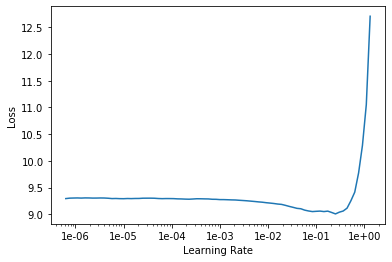

In [85]:
learn.recorder.plot()

In [90]:
learn.fit(20, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,5.789088,5.542234,0.077320,00:25
1,5.811035,5.612938,0.087629,00:25
2,5.883242,5.560423,0.118557,00:25
3,5.808523,5.624767,0.103093,00:25
4,5.842242,5.497799,0.118557,00:25
5,5.776875,5.485713,0.113402,00:25
6,5.863748,5.549132,0.118557,00:25
7,5.875908,5.414258,0.108247,00:25
8,5.823352,5.480169,0.139175,00:25
9,5.836423,5.571071,0.092784,00:26


probably check metrics

In [92]:
learn.save('20epoch')

In [93]:
df.iloc[1]

Account Number           10063906
Suite                         NaN
House Number                 1535
Street Name         37B AVENUE NW
Assessed Value             382500
Assessment Class      Residential
Neighbourhood ID             6443
Neighbourhood            TAMARACK
Ward                      Ward 11
Garage                          Y
Latitude                  53.4735
Longitude                -113.366
Name: 1, dtype: object

In [94]:
learn.predict(df.iloc[1])

(Category 429000,
 tensor(859),
 tensor([3.5940e-05, 8.5167e-05, 1.2250e-04,  ..., 1.9694e-09, 1.2512e-09,
         1.5914e-08]))

In [95]:
df.iloc[2]

Account Number            4252557
Suite                         NaN
House Number                 8409
Street Name         156 AVENUE NW
Assessed Value             348000
Assessment Class      Residential
Neighbourhood ID             2050
Neighbourhood          BELLE RIVE
Ward                       Ward 3
Garage                          Y
Latitude                  53.6162
Longitude                -113.472
Name: 2, dtype: object

In [96]:
learn.predict(df.iloc[2])

(Category 424000,
 tensor(849),
 tensor([1.6712e-04, 1.7215e-04, 4.3011e-04,  ..., 6.8399e-09, 1.1522e-09,
         4.4214e-08]))

In [76]:
dep_var = 'Assessed Value'
cat_names = ['Street Name', 'Assessment Class', 'Neighbourhood ID', 'Ward', 'Garage']
cont_names = ['Latitude', 'Longitude']
procs = [FillMissing, Categorify, Normalize]